<!-- Projeto Desenvolvido por Silmara Cristina Basso  -->
# <font color='blue'>Previsão de demanda</font>
# <font color='blue'>MLOps e Ciclo de Vida de Modelos de Machine Learning</font>
## <font color='blue'>MLFlow</font>
### <font color='blue'>MLOps Stack Para Otimização de Hiperparâmetros com MLflow e Optuna</font>

## Instalação, Carregamento e Gerenciamento de Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
!pip install -q optuna==3.6.1

In [3]:
!pip install -q mlflow==2.14.1

In [4]:
!pip install -q xgboost==2.0.3

In [5]:
!pip install -q seaborn==0.12.2

In [6]:
!pip install --upgrade pip

In [7]:
# Imports
import json
import math
import sklearn
import optuna
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

/Users/silmarabasso/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Silmara" 

Author: Silmara



## Inicializando o Servidor MLflow

Abra um prompt de comando ou terminal, navegue até a pasta do projeto e digite o comando abaixo:

mlflow server --host 127.0.0.1 --port 8282

> Agora conectamos no servidor MLflow:

In [9]:
mlflow.set_tracking_uri("http://127.0.0.1:8282")

Acesse a url acima a partir de outra aba no seu navegador: http://127.0.0.1:8282

## Carregando e Compreendendo os Dados

In [10]:
# Carrega o dataset
df_sil = pd.read_csv("dataset.csv")

In [11]:
# Shape
df_sil.shape

(5000, 11)

In [12]:
# Amostra dos dados
df_sil.head()

data  temperatura_media  precipitacao  fim_de_semana  \
0  2010-10-18 09:16:07.883826          30.584727      1.199291              0   
1  2010-10-19 09:16:07.883825          15.465069      1.037626              0   
2  2010-10-20 09:16:07.883824          10.786525      5.656089              0   
3  2010-10-21 09:16:07.883823          23.648154     12.030937              0   
4  2010-10-22 09:16:07.883822          13.861391      4.303812              0   

   feriado  preco_por_kg  promocao      demanda  demanda_dos_dias_anteriores  \
0        0      1.726258         1  1051.375336                  1051.276659   
1        0      0.576471         1  1106.855943                  1051.276659   
2        0      2.513328         1  1008.304909                  1106.836626   
3        0      1.839225         1   999.833810                  1057.895424   
4        0      1.531772         1  1183.949061                  1048.961007   

   preco_por_kg_do_concorrente  intensidade_de_marketing  
0                     1.935346                  0.098677  
1                     2.344720                  0.019318  
2                     0.998803                  0.409485  
3                     0.761740                  0.872803  
4                     2.123436                  0.820779

In [13]:
# Tipos dos dados
df_sil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data                         5000 non-null   object 
 1   temperatura_media            5000 non-null   float64
 2   precipitacao                 5000 non-null   float64
 3   fim_de_semana                5000 non-null   int64  
 4   feriado                      5000 non-null   int64  
 5   preco_por_kg                 5000 non-null   float64
 6   promocao                     5000 non-null   int64  
 7   demanda                      5000 non-null   float64
 8   demanda_dos_dias_anteriores  5000 non-null   float64
 9   preco_por_kg_do_concorrente  5000 non-null   float64
 10  intensidade_de_marketing     5000 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 429.8+ KB


In [14]:
# Vamos ajustar a coluna de data para o tipo correto
df_sil['data'] = pd.to_datetime(df_sil['data'])

In [15]:
# Tipos dos dados
df_sil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   data                         5000 non-null   datetime64[ns]
 1   temperatura_media            5000 non-null   float64       
 2   precipitacao                 5000 non-null   float64       
 3   fim_de_semana                5000 non-null   int64         
 4   feriado                      5000 non-null   int64         
 5   preco_por_kg                 5000 non-null   float64       
 6   promocao                     5000 non-null   int64         
 7   demanda                      5000 non-null   float64       
 8   demanda_dos_dias_anteriores  5000 non-null   float64       
 9   preco_por_kg_do_concorrente  5000 non-null   float64       
 10  intensidade_de_marketing     5000 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)


In [16]:
# Resumo estatístico
df_sil.describe()

data  temperatura_media  precipitacao  \
count                           5000        5000.000000   5000.000000   
mean   2017-08-21 21:16:07.881014528          22.433182      4.962877   
min       2010-10-18 09:16:07.883826          10.002439      0.000071   
25%    2014-03-21 03:16:07.882367232          16.311898      1.440718   
50%    2017-08-21 21:16:07.881031424          22.400265      3.520515   
75%    2021-01-22 15:16:07.879706624          28.570768      6.805668   
max       2024-06-25 09:16:07.878116          34.995334     40.072693   
std                              NaN           7.146610      4.932382   

       fim_de_semana      feriado  preco_por_kg     promocao      demanda  \
count    5000.000000  5000.000000   5000.000000  5000.000000  5000.000000   
mean        0.285600     0.033000      1.758228     0.289000  1258.452333   
min         0.000000     0.000000      0.500360     0.000000   707.952882   
25%         0.000000     0.000000      1.134110     0.000000  1066.040653   
50%         0.000000     0.000000      1.776194     0.000000  1222.237635   
75%         1.000000     0.000000      2.383638     1.000000  1422.792698   
max         1.000000     1.000000      2.999606     1.000000  2183.463942   
std         0.451745     0.178654      0.725334     0.453343   253.240475   

       demanda_dos_dias_anteriores  preco_por_kg_do_concorrente  \
count                  5000.000000                  5000.000000   
mean                   1282.446665                     1.769682   
min                     757.216503                     0.500754   
25%                    1089.993191                     1.160719   
50%                    1244.619215                     1.764809   
75%                    1445.791858                     2.401827   
max                    2182.608701                     2.999847   
std                     249.087488                     0.721041   

       intensidade_de_marketing  
count               5000.000000  
mean                   0.848173  
min                    0.019318  
25%                    0.773080  
50%                    0.848107  
75%                    0.928536  
max                    0.999979  
std                    0.093135

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Carregando e Compreendendo os Metadados (Dicionário)

In [17]:
# Carrega o arquivo JSON
with open('dicionario_de_dados.json', 'r') as arquivo:
    dicionario_de_dados = json.load(arquivo)

In [18]:
# Cria um DataFrame a partir do dicionário de metadados
df_dict = pd.DataFrame.from_dict(dicionario_de_dados, orient = 'index')

In [19]:
# Não truncar colunas no Pandas
pd.set_option('display.max_colwidth', None)

In [20]:
df_dict

descrição  \
data                                                                          Data e hora em que os dados foram registrados.   
temperatura_media                                                                      Temperatura média registrada na data.   
precipitacao                                                                  Quantidade de precipitação registrada na data.   
fim_de_semana                                                             Indica se o dia é um fim de semana (1) ou não (0).   
feriado                                                                         Indica se o dia é um feriado (1) ou não (0).   
preco_por_kg                                                                                Preço por kg do produto vendido.   
promocao                                                                  Indica se havia uma promoção ativa (1) ou não (0).   
demanda                                                                                          Demanda do produto na data.   
demanda_dos_dias_anteriores                                                              Demanda do produto no dia anterior.   
preco_por_kg_do_concorrente                                            Preço por kg do produto oferecido por um concorrente.   
intensidade_de_marketing     Nível de intensidade das atividades de marketing (campanhas, anúncios) relacionadas ao produto.   

                                 tipo  
data                         datetime  
temperatura_media               float  
precipitacao                    float  
fim_de_semana                     int  
feriado                           int  
preco_por_kg                    float  
promocao                          int  
demanda                         float  
demanda_dos_dias_anteriores     float  
preco_por_kg_do_concorrente     float  
intensidade_de_marketing        float

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Funções de Exploração e Visualização dos Dados Para o Experimento

In [22]:
# Função para o plot da correlação das variáveis preditoras com a variável alvo (demanda)
def plot_corr_demanda(df, save_path = None):

    # Calcula as correlações das variáveis com a demanda, exceto a própria demanda
    correlations = df.corr()["demanda"].drop("demanda").sort_values()

    # Define uma paleta de cores divergentes
    colors = sns.diverging_palette(10, 130, as_cmap = True)
    
    # Mapeia as cores às correlações
    color_mapped = correlations.map(colors)

    # Define o estilo do gráfico
    sns.set_style("darkgrid", {"axes.facecolor": "#eaeaf2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de barras horizontais para as correlações
    plt.barh(correlations.index, correlations.values, color = color_mapped)

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Correlação com Demanda", fontsize = 16)
    plt.xlabel("Coeficiente de Correlação", fontsize = 14)
    plt.ylabel("Variável", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(axis="x")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [23]:
# Executa a função
grafico1 = plot_corr_demanda(df_sil)

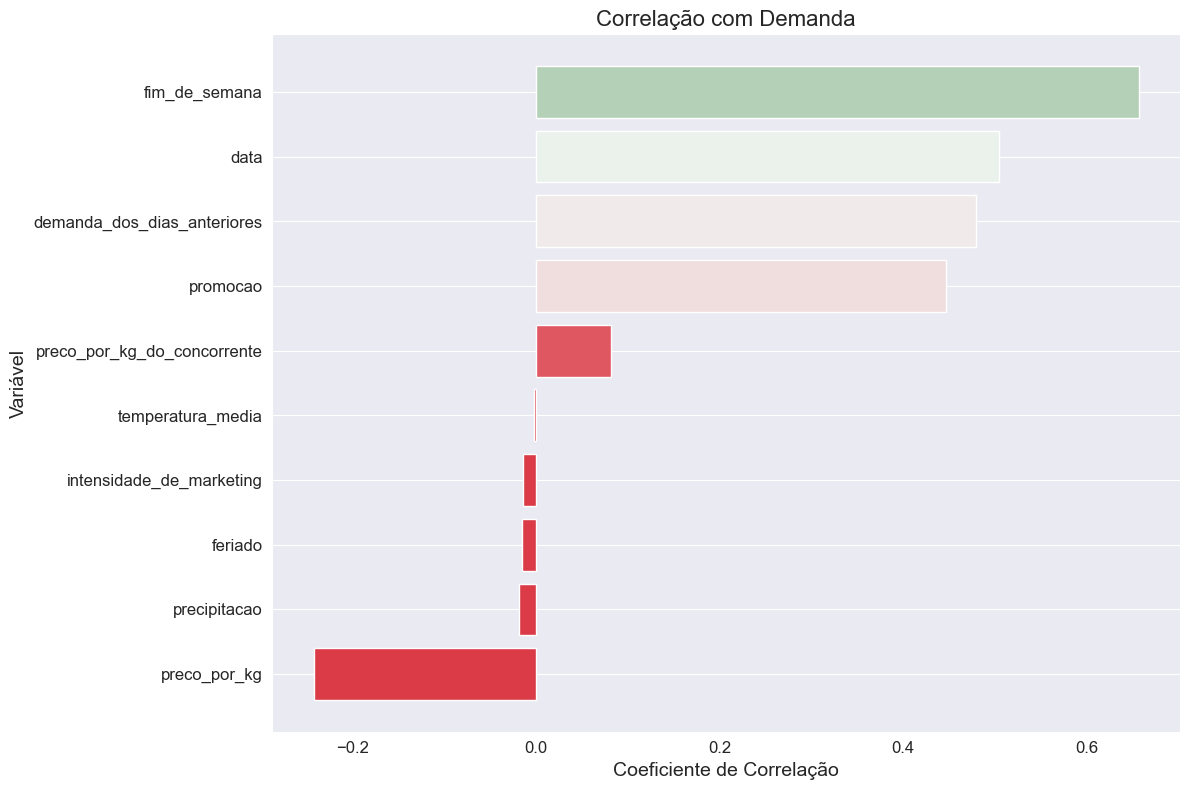

In [24]:
grafico1

In [25]:
# Função para plot dos resíduos do modelo
def plot_residuos(model, dvalid, valid_y, save_path = None):

    # Faz as previsões no conjunto de validação
    preds = model.predict(dvalid)

    # Calcula os resíduos (diferença entre valores reais e previstos)
    residuals = valid_y - preds

    # Define o estilo do gráfico para 'whitegrid'
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de dispersão dos valores reais versus resíduos
    plt.scatter(valid_y, residuals, color = "blue", alpha = 0.5)
    
    # Adiciona uma linha horizontal em y=0
    plt.axhline(y = 0, color = "r", linestyle = "-")

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Resíduos x Valores Reais", fontsize = 16)
    plt.xlabel("Valores Reais", fontsize = 14)
    plt.ylabel("Resíduos", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(axis = "y")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [26]:
# Função para plot da importância das variáveis
def plot_feature_importance(model, booster):

    # Cria a figura e o eixo para o plot com tamanho definido
    fig, ax = plt.subplots(figsize = (10, 8))
    
    # Define o tipo de importância como "weight" se o booster for "gblinear", caso contrário "gain"
    importance_type = "weight" if booster == "gblinear" else "gain"
    
    # Plot das importância das variáveis usando o XGBoost
    xgb.plot_importance(model,
                        importance_type = importance_type,
                        ax = ax,
                        title = f"Feature Importance baseada em {importance_type}")
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    
    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

## Criando o Experimento no MLflow

In [27]:
# Função para criar o experimento
def cria_experimento(experiment_name):

    # Verifica se o experimento já existe pelo nome
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # Se o experimento existir, retorna seu ID
        return experiment.experiment_id
    else:
        # Se o experimento não existir, cria um novo e retorna seu ID
        return mlflow.create_experiment(experiment_name)

In [ ]:
# Cria o experimento
id_experimento = cria_experimento("MLflowOptuna_v1")

In [29]:
# Experimento criado
id_experimento

'650737912798334645'

Visualize no seu navegador: http://127.0.0.1:8282

In [30]:
# Define o experimento MLflow ativo atual
mlflow.set_experiment(experiment_id = id_experimento)

<Experiment: artifact_location='mlflow-artifacts:/650737912798334645', creation_time=1751756172211, experiment_id='650737912798334645', last_update_time=1751756172211, lifecycle_stage='active', name='MLflowOptuna', tags={}>

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Pré-Processamento dos Dados Para o Experimento

Acompanhe o videobook no Capítulo 6 do curso.

In [32]:
# Separa em X e y
X = df_sil.drop(columns = ["data", "demanda"])
y = df_sil["demanda"]

In [33]:
# Divide os dados em treino e validação
x_treino, x_valid, y_treino, y_valid = train_test_split(X, y, test_size = 0.25)

In [34]:
# Coloca os dados no formato de matriz do XGBoost
sil_treino = xgb.DMatrix(x_treino, label = y_treino)
sil_valid = xgb.DMatrix(x_valid, label = y_valid)

In [35]:
# Substitui o registro padrão do Optuna apenas para ERROR
optuna.logging.set_verbosity(optuna.logging.ERROR)

## Definindo o Callback de Logging

Registro de retorno de chamada que informará quando uma nova iteração de teste melhorar a existente.

In [36]:
# Função de callback
def sil_callback(study, frozen_trial):

    # Obtém o valor atual do "winner" (vencedor) dos atributos do estudo
    winner = study.user_attrs.get("winner", None)

    # Verifica se há um novo melhor valor e se o "winner" não é igual ao melhor valor
    if study.best_value and winner != study.best_value:
        
        # Define o novo melhor valor como "winner"
        study.set_user_attr("winner", study.best_value)
        
        # Se havia um "winner" anterior
        if winner:
            
            # Calcula a porcentagem de melhoria em relação ao "winner" anterior
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            
            # Imprime o número da tentativa, o valor alcançado e a porcentagem de melhoria
            print(
                f"Tentativa {frozen_trial.number} alcançou o valor: {frozen_trial.value} com "
                f"{improvement_percent: .4f}% de melhora na métrica de avaliação.")
        else:
            # Se não havia um "winner" anterior, imprime o número da tentativa inicial e o valor alcançado
            print(
                f"Tentativa inicial {frozen_trial.number} alcançou o valor: "
                f"{frozen_trial.value} na métrica de avaliação.")

## Definindo os Hiperparâmetros do XGBoost Para o Experimento

Acompanhe o videobook no Capítulo 6 do curso.

In [37]:
# Função para definir os hiperparâmetros que serão otimizados
def otimiza_hiperparametro(trial):
    
    # Inicia uma nova execução de MLflow
    with mlflow.start_run(nested = True):
        
        # Define os hiperparâmetros básicos do modelo
        params = {
            
            # Função alvo (objetivo)
            "objective": "reg:squarederror",
            
            # Métrica de avaliação
            "eval_metric": "rmse",
            
            # Tipo de booster (algoritmo de treinamento)
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            
            # Valor de lambda para regularização L2
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log = True),
            
            # Valor de alpha para regularização L1
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log = True),
        }

        # Se o booster for 'gbtree' ou 'dart', adiciona parâmetros específicos
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            
            # Profundidade máxima da árvore
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            
            # Valor de eta (taxa de aprendizado)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            
            # Valor de gamma para regularização adicional
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            
            # Política de crescimento das árvores
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Treina o modelo com os hiperparâmetros escolhidos
        bst = xgb.train(params, sil_treino)
        
        # Faz previsões no conjunto de validação
        preds = bst.predict(sil_valid)
        
        # Calcula o erro quadrático médio
        error = mean_squared_error(y_valid, preds)

        # Registra os parâmetros no MLflow
        mlflow.log_params(params)
        
        # Registra o MSE no MLflow
        mlflow.log_metric("mse", error)
        
        # Registra o RMSE no MLflow
        mlflow.log_metric("rmse", math.sqrt(error))

    # Retorna o erro calculado
    return error

## Executando o Experimento com MLflow e Optuna

In [38]:
# Nome para a execução no MLflow
run_name = "mlflow"

In [39]:
# Inicia a execução de ajuste de hiperparâmetros
with mlflow.start_run(experiment_id = id_experimento, run_name = run_name, nested = True):
    
    # Cria um estudo Optuna para otimização de hiperparâmetros para minimizar a função alvo (função de erro)
    study = optuna.create_study(direction = "minimize")

    # Otimiza os hiperparâmetros com 500 tentativas, usando a função de callback
    study.optimize(otimiza_hiperparametro, n_trials = 500, callbacks = [sil_callback])

    # Registra os melhores hiperparâmetros encontrados no MLflow
    mlflow.log_params(study.best_params)
    
    # Registra o melhor valor de MSE encontrado no MLflow
    mlflow.log_metric("best_mse", study.best_value)
    
    # Calcula e registra o melhor valor de RMSE no MLflow
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Define tags para a execução no MLflow
    mlflow.set_tags(tags = {"project": "MLFlow e Optuna",
                            "optimizer_engine": "optuna",
                            "model_family": "xgboost",
                            "feature_set_version": 1})

    # Treina o modelo com os melhores parâmetros encontrados
    model = xgb.train(study.best_params, sil_treino)

    # Registra o gráfico grafico1 no MLflow
    mlflow.log_figure(figure = grafico1, artifact_file = "grafico1.png")

    # Plota e registra a importância das variáveis no MLflow
    importances = plot_feature_importance(model, booster = study.best_params.get("booster"))
    mlflow.log_figure(figure = importances, artifact_file = "grafico2.png")

    # Plota e registra os resíduos no MLflow
    residuals = plot_residuos(model, sil_valid, y_valid)
    mlflow.log_figure(figure = residuals, artifact_file = "grafico3.png")

    # Define o caminho do artefato do modelo
    artifact_path = "model"

    # Registra o modelo treinado no MLflow
    mlflow.xgboost.log_model(xgb_model = model,
                             artifact_path = artifact_path,
                             input_example = x_treino.iloc[[0]],
                             model_format = "ubj",
                             metadata = {"model_data_version": 1})

    # Obtém a URI do artefato do modelo registrado
    model_uri = mlflow.get_artifact_uri(artifact_path)

Tentativa inicial 0 alcançou o valor: 21170.296500783243 na métrica de avaliação.
Tentativa 4 alcançou o valor: 20926.655703792214 com  1.1643% de melhora na métrica de avaliação.
Tentativa 5 alcançou o valor: 20909.64017786472 com  0.0814% de melhora na métrica de avaliação.
Tentativa 10 alcançou o valor: 18641.08727757764 com  12.1696% de melhora na métrica de avaliação.
Tentativa 45 alcançou o valor: 18190.1856864442 com  2.4788% de melhora na métrica de avaliação.
Tentativa 52 alcançou o valor: 18143.470411560123 com  0.2575% de melhora na métrica de avaliação.
Tentativa 55 alcançou o valor: 17744.138927297365 com  2.2505% de melhora na métrica de avaliação.
Tentativa 81 alcançou o valor: 17676.512954211837 com  0.3826% de melhora na métrica de avaliação.
Tentativa 88 alcançou o valor: 16990.687974434808 com  4.0365% de melhora na métrica de avaliação.
Tentativa 103 alcançou o valor: 16975.69201234278 com  0.0883% de melhora na métrica de avaliação.
Tentativa 105 alcançou o valor: 

Visualize no seu navegador: http://127.0.0.1:8282

## Carregando o Modelo a Partir dos Artefatos

In [40]:
# Caminho para o melhor modelo (com melhor combinação de hiperparâmetros) salvo em disco
model_uri

'mlflow-artifacts:/650737912798334645/850ac89ac3fe45d9a2e817ed91016998/artifacts/model'

In [41]:
# Carrega o melhor modelo do disco
melhor_modelo = mlflow.xgboost.load_model(model_uri)

## Pipeline de Inferência com o Melhor Modelo

In [42]:
# Gera um batch de dados a partir de X (variáveis preditoras)
batch_dmatrix = xgb.DMatrix(X)

In [43]:
# Faz a inferência (previsões) usando o melhor modelo - ATENÇÃO: ISSO NÃO É DEPLOY!!!!
inferencia = melhor_modelo.predict(batch_dmatrix)

In [44]:
# Cria cópia do dataframe original
df_final = df_sil.copy()

In [45]:
# Cria uma coluna com as previsões
df_final["demanda_prevista"] = inferencia

In [46]:
df_final.sample(10)

data  temperatura_media  precipitacao  \
4721 2023-09-21 09:16:07.878467          22.021033      6.860636   
4913 2024-03-31 09:16:07.878232          18.023862      0.441724   
1154 2013-12-15 09:16:07.882468          33.210065      3.349390   
2891 2018-09-17 09:16:07.880622          24.214390      7.239076   
3669 2020-11-03 09:16:07.879807          16.705227      0.784369   
4752 2023-10-22 09:16:07.878428          28.073758      1.740560   
1318 2014-05-28 09:16:07.882296          33.474865      1.449758   
4739 2023-10-09 09:16:07.878444          30.801304      0.867268   
2134 2016-08-21 09:16:07.881417          27.140674     14.628917   
1527 2014-12-23 09:16:07.882072          26.459405      0.277307   

      fim_de_semana  feriado  preco_por_kg  promocao      demanda  \
4721              0        0      2.673620         0  1213.164988   
4913              1        0      0.859965         1  2016.982649   
1154              1        0      1.627104         0  1252.277880   
2891              0        0      1.062459         0  1166.140274   
3669              0        0      0.603941         0  1325.197386   
4752              1        0      0.620871         1  1948.206850   
1318              0        0      1.101722         0  1033.874593   
4739              0        0      0.520371         1  1610.769224   
2134              1        0      1.161751         0  1408.902733   
1527              0        0      1.316353         1  1217.537232   

      demanda_dos_dias_anteriores  preco_por_kg_do_concorrente  \
4721                  1352.182862                     1.471610   
4913                  1704.861995                     1.072846   
1154                  1344.389222                     0.861875   
2891                  1705.342916                     0.800631   
3669                  1118.134749                     2.719052   
4752                  1973.919877                     1.154931   
1318                   995.818806                     2.096592   
4739                  1879.305063                     2.420125   
2134                  1283.003291                     2.275057   
1527                   986.064091                     1.931090   

      intensidade_de_marketing  demanda_prevista  
4721                  0.797277       1050.470825  
4913                  0.953573       1847.953369  
1154                  0.927883       1398.408813  
2891                  0.981052       1221.353638  
3669                  0.905311       1178.679321  
4752                  0.804063       1870.588013  
1318                  0.867072       1042.926025  
4739                  0.746836       1554.747681  
2134                  0.754601       1472.592285  
1527                  0.971998       1215.786743

Projeto concluído com sucesso! Cliente feliz. Partimos para o próximo projeto.

In [47]:
%reload_ext watermark
%watermark -a "Silmara"

Author: Silmara



In [ ]:
#%watermark -v -m

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 9.4.0

Compiler    : Clang 15.0.0 (clang-1500.1.0.2.5)
OS          : Darwin
Release     : 23.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit



In [ ]:
#%watermark --iversions

json      : 2.0.9
seaborn   : 0.12.2
xgboost   : 2.0.3
sklearn   : 1.7.0
pandas    : 2.3.0
optuna    : 3.6.1
numpy     : 1.26.4
matplotlib: 3.10.3
mlflow    : 2.14.1



# Fim